In [12]:
# Import the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV

# Read the data
data = pd.read_csv("../data/cleaned/04_08_finwlabel.csv", low_memory=False)

In [13]:
# Exclude the specified columns
exclude_columns = ['Reporting Period End Date', 'OCC Charter Number', 'OTS Docket Number',
                   'Primary ABA Routing Number', 'Financial Institution Filing Type', 'CERT', 'date',
                   'date_index', 'last', 'survival']

feature_columns = [col for col in data.columns if col not in exclude_columns]

# Select rows based on date_index for training and prediction
train_data = data[data['date_index'].isin([1, 6, 11, 16])].reset_index(drop=True)

# Drop columns with more than 10% NAs
columns_with_too_many_nas = train_data.columns[train_data.isna().mean() > 0.1]
train_data = train_data.drop(columns_with_too_many_nas, axis=1)

# Update feature_columns to only include columns that were not dropped
feature_columns = [col for col in feature_columns if col not in columns_with_too_many_nas]

# Fill remaining NAs with 0
train_data.fillna(0, inplace=True)

# Select a subset of train_data for feature selection
train_data_subset = train_data.sample(frac=0.005, random_state=42)

# Feature selection using Recursive Feature Elimination with Cross-Validation (RFECV)
cv = TimeSeriesSplit(n_splits=5)
rfecv = RFECV(RandomForestRegressor(random_state=42), step=1, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
rfecv.fit(train_data_subset[feature_columns], train_data_subset['last'])

# Select the top 15 features based on the feature importances
feature_importances = rfecv.estimator_.feature_importances_
sorted_features = sorted(zip(feature_columns, feature_importances), key=lambda x: x[1], reverse=True)
selected_features = [feature[0] for feature in sorted_features[:15]]
print(f'Selected features: {selected_features}')

Selected features: ['RIADA220', 'RCON1773', 'RCON3506', 'RIAD4180', 'RIADB493', 'RIADC386', 'RIAD4012', 'RCON6560', 'RCON6558', 'RIAD4185', 'RCON1606', 'RIAD9106', 'RIADA530', 'IDRSSD.1', 'RCON5369']


In [14]:
# y_dict = dict(zip(data['CERT'],data['last']))
y = data[['CERT','last']]
idx = y.groupby(['CERT'])['last'].idxmax()
y = y.loc[idx]

In [15]:
def flatten_data(data, date_indices):
    flattened_data = []

    for _, group in data.groupby('CERT'):
        flattened_row = {'CERT': group['CERT'].iloc[0]}

        for index in date_indices:
            index_data = group[group['date_index'] == index]
            if not index_data.empty:
                for feature in selected_features:
                    flattened_row[f'{feature}_{index}'] = index_data[feature].values[0]

        flattened_data.append(flattened_row)

    return pd.DataFrame(flattened_data)


# Flatten the data and keep only the selected features
X = flatten_data(data[selected_features + ['CERT', 'date_index']], [1, 6, 11, 16])

In [16]:
from sklearn.model_selection import train_test_split

# Train/ Test split
all_data = X.merge(y)
all_data = all_data.fillna(0)

train_ratio = 0.8
test_ratio = 1 - train_ratio

filtered_data = all_data.query('last != 20')

# Split the DataFrame into train and test sets
train_data, test_data = train_test_split(filtered_data, test_size=test_ratio, random_state=42)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Assuming train_data and test_data are already defined
# Perform train/validation split
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(['CERT', 'last'], axis=1),
                                                  train_data[['last']],
                                                  test_size=0.2, random_state=42)

# Standardize the data (neural networks often perform better with standardized data)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_data.drop(['CERT', 'last'], axis=1))

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(test_data[['last']].values, dtype=torch.float32)


In [18]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create custom datasets
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [19]:
import torch.nn as nn

class NeuralNetworkMultiClassification(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetworkMultiClassification, self).__init__()
        self.lrelu = nn.LeakyReLU(0.1)
        self.drop = nn.Dropout(0.5)
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.layer5 = nn.Linear(128, 64)
        self.layer6 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(self.lrelu(self.layer2(x)) + x)
        x = self.drop(x)
        x = self.layer3(x)
        x = self.bn2(self.lrelu(self.layer4(x)) + x)
        x = self.drop(x)
        x = self.lrelu(self.layer5(x))
        x = self.layer6(x)
        return nn.functional.softmax(x, dim=1)

input_size = X_train.shape[1]
num_classes = 20
model = NeuralNetworkMultiClassification(input_size, num_classes)
# Set device
device = torch.device("mps")
model.to(device)

NeuralNetworkMultiClassification(
  (lrelu): LeakyReLU(negative_slope=0.1)
  (drop): Dropout(p=0.5, inplace=False)
  (layer1): Linear(in_features=60, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Linear(in_features=128, out_features=64, bias=True)
  (layer6): Linear(in_features=64, out_features=20, bias=True)
)

In [20]:
from torch.optim.lr_scheduler import StepLR

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
# Training and validation loop
n_epochs = 100
for epoch in range(n_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch -= 1
        y_batch = y_batch.squeeze()
        y_batch = y_batch.long()
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        train_loss += loss.item() * X_batch.size(0)
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(y_pred, 1)
        correct_preds += (predicted == y_batch).sum().item()
        total_preds += y_batch.size(0)


    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_preds / total_preds
    train_accuracies.append(train_accuracy)
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch -= 1
            y_batch = y_batch.squeeze()
            y_batch = y_batch.long()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(y_pred, 1)
            correct_preds += (predicted == y_batch).sum().item()
            total_preds += y_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_preds / total_preds
    val_accuracies.append(val_accuracy)
    # Print progress
    if (epoch % 10 == 0):
        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

Epoch 1/100: Train Loss = 2.9903, Val Loss = 2.9874
Epoch 11/100: Train Loss = 2.7970, Val Loss = 2.8558
Epoch 21/100: Train Loss = 2.7541, Val Loss = 2.8477
Epoch 31/100: Train Loss = 2.7496, Val Loss = 2.8496
Epoch 41/100: Train Loss = 2.7440, Val Loss = 2.8421
Epoch 51/100: Train Loss = 2.7395, Val Loss = 2.8495
Epoch 61/100: Train Loss = 2.7439, Val Loss = 2.8440
Epoch 71/100: Train Loss = 2.7323, Val Loss = 2.8486
Epoch 81/100: Train Loss = 2.7295, Val Loss = 2.8452
Epoch 91/100: Train Loss = 2.7346, Val Loss = 2.8544


In [21]:
# Save the trained model
model_save_path = "my_classification_model2.pth"
torch.save(model.state_dict(), model_save_path)


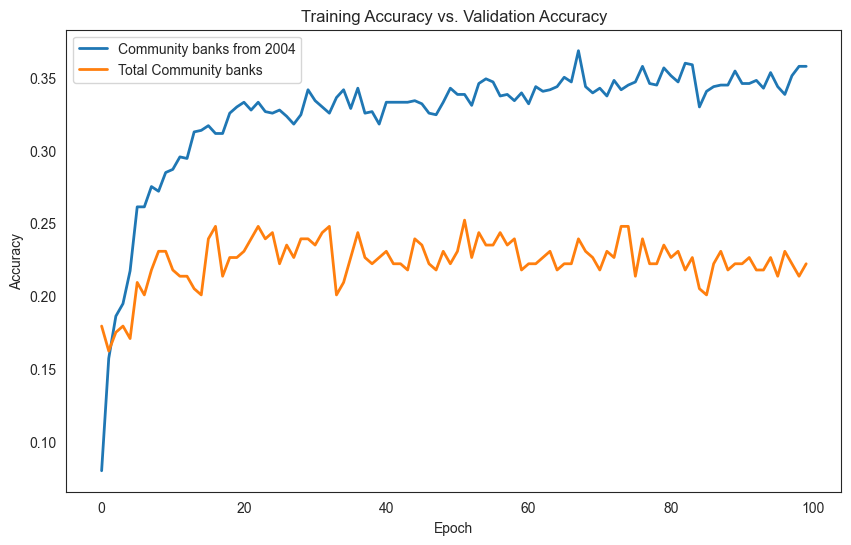

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the data
length = len(val_accuracies)
sns.lineplot(x=range(length), y=train_accuracies, linewidth=2, label='Community banks from 2004')
sns.lineplot(x=range(length), y=val_accuracies, linewidth=2, label='Total Community banks')

# Set plot title and axis labels
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()
plt.savefig("../image/nn_classification_performence.png", format='png')
# Show the plot
plt.show()

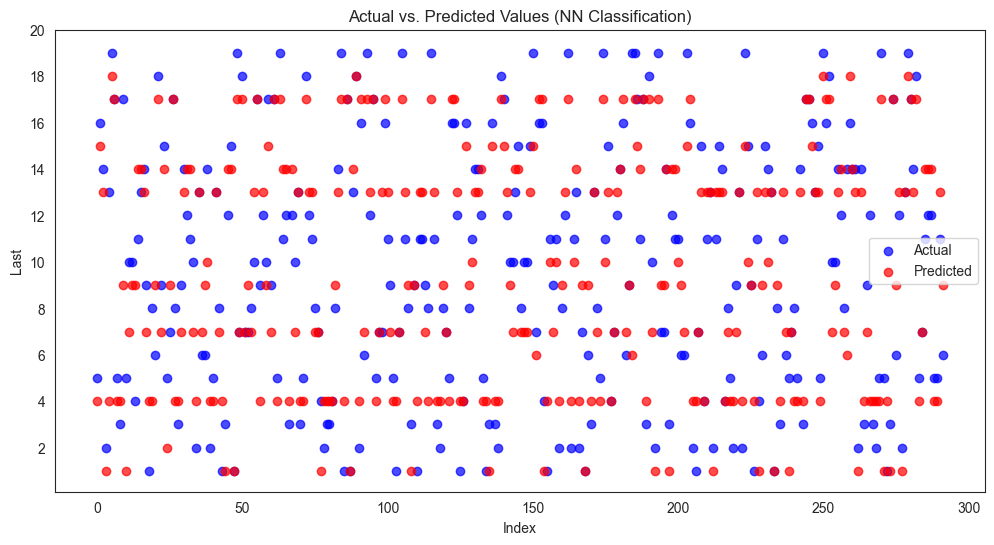

In [23]:
# Make predictions on the test data
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_pred = model(X_test).cpu()
    y_pred = np.argmax(y_pred, axis=1).numpy()

# Create a plot to visualize the difference between actual and predicted values
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7)
plt.scatter(np.arange(len(y_test)), y_pred, label='Predicted', color='red', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Last')
plt.title('Actual vs. Predicted Values (NN Classification)')
plt.legend()
plt.yticks(range(2, 21, 2))
plt.savefig("../image/nn_classification_prediction.png", format='png')
plt.show()